In [2]:
from pathlib import Path, PurePath
import git
import random
from typing import List
from collections import Counter

import pandas as pd

from matplotlib import pyplot as plt 

In [3]:
# load datasets
if 'google.colab' not in str(get_ipython()):
    use_fp16 = False
    PROJECT_ROOT = git.Repo(PurePath(), search_parent_directories=True).git.rev_parse("--show-toplevel")
    DATA_ROOT = PurePath(PROJECT_ROOT, "data")
else:
    from google.colab import drive
    use_fp16 = True
    drive.mount('/content/drive')
    PROJECT_ROOT = PurePath('')
    DATA_ROOT = Path('/content/drive/MyDrive/twitter-datasets')


with open(PurePath(DATA_ROOT, 'train_pos.txt'), 'r', encoding='utf-8') as fp:
    train_pos_sub = fp.readlines()

with open(PurePath(DATA_ROOT, 'train_neg.txt'), 'r', encoding='utf-8') as fp:
    train_neg_sub = fp.readlines()

with open(PurePath(DATA_ROOT, 'train_pos_full.txt'), 'r', encoding='utf-8') as fp:
    train_pos_full = fp.readlines()

with open(PurePath(DATA_ROOT, 'train_neg_full.txt'), 'r', encoding='utf-8') as fp:
    train_neg_full = fp.readlines()

with open(PurePath(DATA_ROOT, 'test_data.txt'), 'r', encoding='utf-8') as fp:
    test_full = fp.readlines()

def load_dataset(ratio=0.01):
    if type(ratio) is int:
        ratio = float(ratio)
    assert isinstance(ratio, str) or isinstance(ratio, float)
    if type(ratio) is float:
        if ratio <= 0 or ratio > 1:
            raise AttributeError('The input should be \'full\', \'sub\', or a (float) number between 0 and 1')
        num_samples = int(ratio*len(train_pos_full))
        return random.sample(train_pos_full, num_samples), random.sample(train_neg_full, num_samples)
    else:
        if ratio == 'full':
            return train_pos_full, train_neg_full
        elif ratio == 'sub':
            return train_pos_sub, train_neg_sub
        else:
            raise AttributeError('The input should be \'full\', \'sub\', or a (float) number between 0 and 1')

data_pos, data_neg = load_dataset(1)
print(len(data_pos), len(data_neg), len(test_full))

1250000 1250000 10000


# Hashtag Exploration

In [4]:
def extract_hashtag(text_list: list) -> List:
    hashtag_list = []
    sentence_count = 0
    for text in text_list:
        for word in text.split():
            if word[0] == '#':
                hashtag = word[1:]
                if len(hashtag) != 0:
                    hashtag_list.append(hashtag)
                    sentence_count += 1
    return hashtag_list, sentence_count


In [5]:
hashtag_pos, hashtag_pos_sentence_count = extract_hashtag(data_pos)
hashtag_neg, hashtag_neg_sentence_count = extract_hashtag(data_neg)
hashtag_test, hashtag_test_sentence_count = extract_hashtag(test_full)


In [6]:
hashtag_pos_count = Counter(hashtag_pos)
hashtag_pos_count = sorted(hashtag_pos_count.items(), key=lambda x: x[1], reverse=True)

hashtag_neg_count = Counter(hashtag_neg)
hashtag_neg_count = sorted(hashtag_neg_count.items(), key=lambda x: x[1], reverse=True)

hashtag_test_count = Counter(hashtag_test)
hashtag_test_count = sorted(hashtag_test_count.items(), key=lambda x: x[1], reverse=True)


In [7]:
hashtag_ratio_pos = 100 * hashtag_pos_sentence_count / len(data_pos)
hashtag_ratio_neg = 100 * hashtag_neg_sentence_count / len(data_neg)
hashtag_ratio_test = 100 * hashtag_test_sentence_count / len(test_full)
print("Positive hashtagged sentences:  " + str(hashtag_ratio_pos) + " %")
print("Negative hashtagged sentences:  " + str(hashtag_ratio_neg) + " %")
print("Hashtagged sentences in the test set:  " + str(hashtag_ratio_test) + " %")


Positive hashtagged sentences:  17.08776 %
Negative hashtagged sentences:  11.11048 %
Hashtagged sentences in the test set:  13.01 %


In [8]:
pos_df = pd.DataFrame(hashtag_pos_count, columns=['Hashtag', 'PosFreq']).set_index('Hashtag')
neg_df = pd.DataFrame(hashtag_neg_count, columns=['Hashtag', 'NegFreq']).set_index('Hashtag')

In [9]:
full_df = pd.concat([pos_df, neg_df]).fillna(0)

In [10]:
full_df['PosRatio'] =  full_df['PosFreq'] / (full_df['PosFreq'] + full_df['NegFreq'])
full_df['NegRatio'] =  1 - full_df['PosRatio']

In [11]:
full_df.describe()

,PosFreq,NegFreq,PosRatio,NegRatio
count,126261.000000,126261.000000,126261.000000,126261.000000
mean,1.691710,1.099952,0.586389,0.413611
std,22.597294,11.012325,0.492482,0.492482
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,4147.000000,1771.000000,1.000000,1.000000


In [12]:
full_df['PosRatio'].unique(), full_df['NegRatio'].unique()

(array([1., 0.]), array([0., 1.]))

<AxesSubplot:>

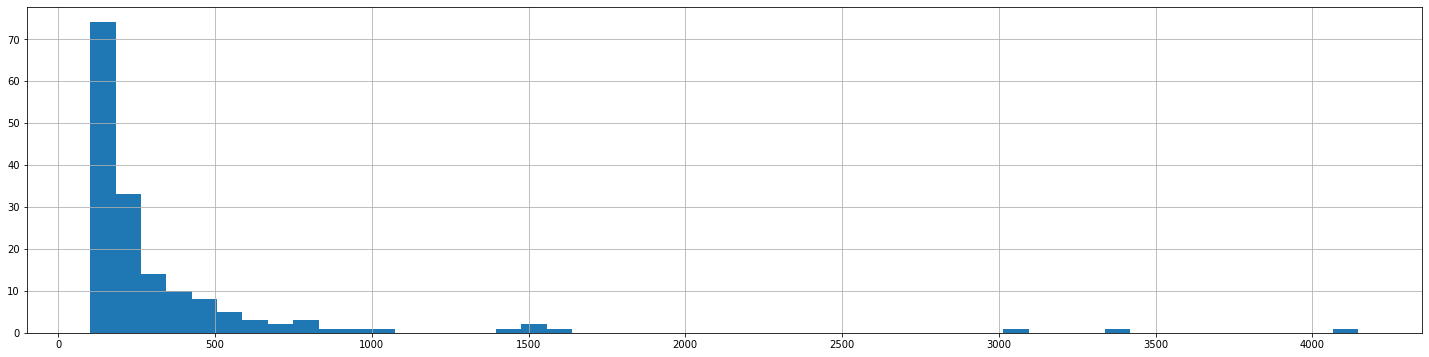

In [13]:
full_df[(full_df.PosFreq>100)].PosFreq.hist(bins=50, figsize=(25,6))

<AxesSubplot:>

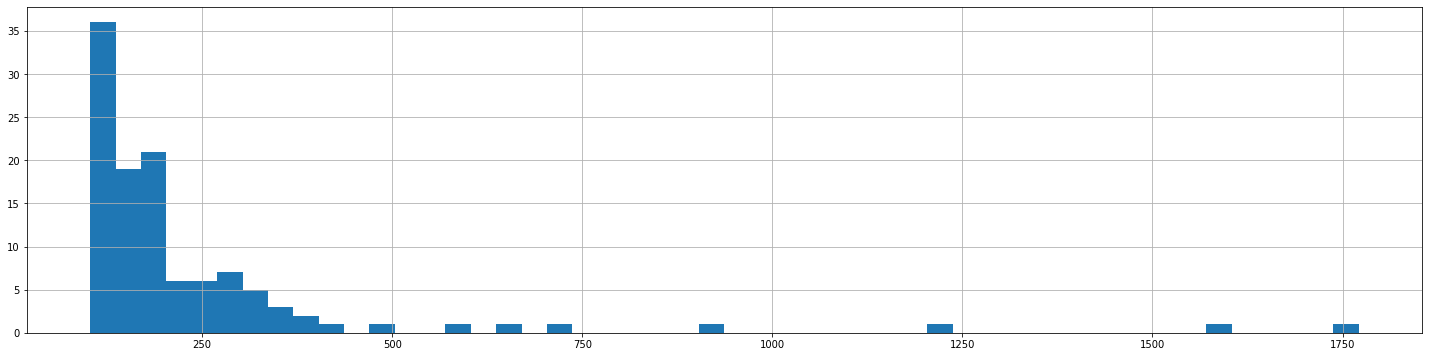

In [14]:
full_df[(full_df.NegFreq>100)].NegFreq.hist(bins=50, figsize=(25,6))

In [15]:
full_df_highfreq = full_df[(full_df.PosFreq>100) | (full_df.NegFreq>100)]
full_df_highfreq.describe()

,PosFreq,NegFreq,PosRatio,NegRatio
count,276.000000,276.000000,276.000000,276.000000
mean,204.358696,100.355072,0.586957,0.413043
std,430.968227,200.846710,0.493275,0.493275
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,117.500000,0.000000,1.000000,0.000000
75%,210.250000,149.250000,1.000000,1.000000
max,4147.000000,1771.000000,1.000000,1.000000


In [16]:
matched_df = full_df_highfreq[full_df_highfreq.index.isin(hashtag_test)]
matched_df

,PosFreq,NegFreq,PosRatio,NegRatio
Hashtag,,,,
ff,4147.0,0.0,1.0,0.0
yougetmajorpointsif,3367.0,0.0,1.0,0.0
oomf,3064.0,0.0,1.0,0.0
teamfollowback,1618.0,0.0,1.0,0.0
smartnokialumia,1530.0,0.0,1.0,0.0
...,...,...,...,...
smh,0.0,114.0,0.0,1.0
thissucks,0.0,113.0,0.0,1.0
notgood,0.0,113.0,0.0,1.0


In [17]:
matched_df.describe()

,PosFreq,NegFreq,PosRatio,NegRatio
count,143.000000,143.000000,143.000000,143.000000
mean,267.615385,125.986014,0.559441,0.440559
std,571.455701,250.847100,0.498199,0.498199
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,119.000000,0.000000,1.000000,0.000000
75%,259.000000,175.500000,1.000000,1.000000
max,4147.000000,1771.000000,1.000000,1.000000


<AxesSubplot:>

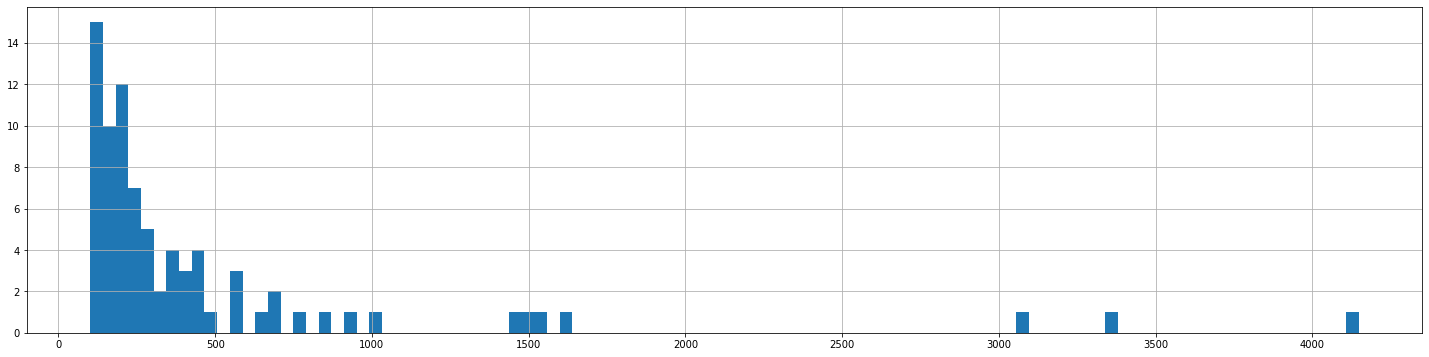

In [27]:
matched_pos = matched_df[matched_df.PosFreq>0]['PosFreq']
matched_pos.hist(bins=100, figsize=(25,6))

<AxesSubplot:>

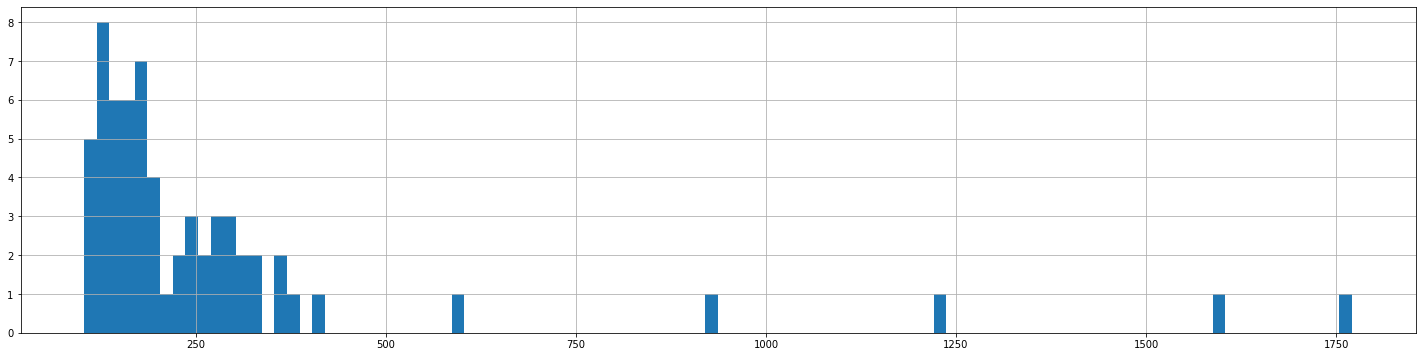

In [26]:
matched_neg = matched_df[matched_df.NegFreq>0]['NegFreq']
matched_neg.hist(bins=100, figsize=(25,6))

#TODO: Slang?

# Length Exploration

# PoS Exploration

# Consecutive Repeating Words Exploration